## Install all Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 895 kB 55.1 MB/s 
     |████████████████████████████████| 596 kB 54.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Load all libraries

In [3]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from transformers import AutoTokenizer, BertModel
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import ast
import json

## Define parameters

In [4]:
MAX_INPUT_LENGTH = 128 #@param {type: "integer"}
MODEL = "nlpaueb/legal-bert-base-uncased" #@param ["nlpaueb/legal-bert-base-uncased", "bert-base-uncased"]
OUTPUT_DIR = "legal-bert-base-two" #@param ["legal-bert-base-two", "test"]
BATCH_SIZE = 16 #@param {type: "integer"}
NUM_EPOCHS = 3 #@param {type: "integer"}
SAVE_STEPS = 100 #@param {type: "integer"}
LOGGING_STEPS = 100 #@param {type: "integer"}
NUM_DATA_POINTS = 100000 #@param {type: 'integer'}

## Creating dataloader
### Load tokenizer
Using tokenizer of pre-existing model, since it's already trained on the same data. It is needed to use the same model.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased",
                                          model_max_length=MAX_INPUT_LENGTH)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Load tagged data is csv

In [6]:
df = pd.read_csv("/content/drive/MyDrive/MRP1/annotated_all.csv", sep="|")

# Set correct type for lists
df.Word = df.Word.apply(ast.literal_eval)
df.Word_idx = df.Word_idx.apply(ast.literal_eval)
df.Tag = df.Tag.apply(ast.literal_eval)

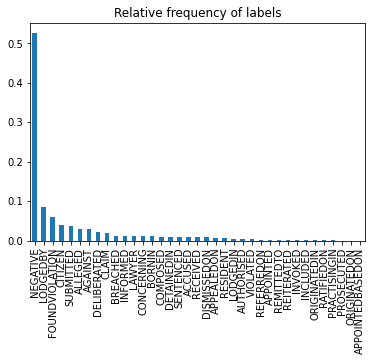

Before:
 NEGATIVE            46032
LODGEDBY             7402
FOUNDVIOLATION       5255
CITIZEN              3525
SUBMITTED            3324
ALLEGED              2594
AGAINST              2575
DELIBERATED          1893
CLAIM                1789
BREACHED             1059
INFORMED             1045
LAWYER                969
CONCERNING            963
BORNIN                961
COMPOSED              900
DETAINEDIN            900
SENTENCED             864
ACCUSED               863
RECEIVED              835
DISMISSEDON           805
APPEALEDON            612
RESIDENT              591
LODGEDIN              351
AUTHORISED            344
VIOLATED              236
REFERREDON            217
APPOINTED             196
REMITTEDTO            136
REITERATED            121
INVOKED                89
INCLUDED               71
ORIGINATEDIN           37
RATIFIEDON             37
PRACTISINGIN           27
PROSECUTED             11
ORIGINATEDON            2
APPOINTEDBASEDON        2
Name: Relation, dtype: int64


In [7]:
# Show frequency labels
(df.Relation.value_counts() / df.Relation.value_counts().sum()).plot(kind='bar')
plt.title("Relative frequency of labels")
plt.show()

# Remove undersampled relations
print("Before:\n", df.Relation.value_counts())

# Remove by selecting labels by hand
df = df[df.Relation.isin(list(df.Relation.value_counts().loc[lambda x: x > 800].index))].reset_index(drop=True)

# Check if it was succesfull
print("\nAfter:\n", df.Relation.value_counts())

In [8]:
# Make function to save idx2tok
def save_dic(d, fn):
  a_file = open("{}.json".format(fn), "w")
  json.dump(d, a_file)
  a_file.close()

def load_dic(fn):
  a_file = open("{}.json".format(fn), "r")
  output = json.loads(a_file.read())
  a_file.close()

  return output

In [9]:
# Create tokenizer for ner tags
vocab = list(set(df.Tag.apply(pd.Series).stack().reset_index(drop = True)))
    
idx2tok_ner = {idx:tok for  idx, tok in enumerate(vocab)}
tok2idx_ner = {tok:idx for  idx, tok in enumerate(vocab)}

# Create tokenizer for relations
vocab = list(set(df.Relation.to_list()))
    
idx2tok_rel = {idx:tok for  idx, tok in enumerate(vocab)}
tok2idx_rel = {tok:idx for  idx, tok in enumerate(vocab)}

# Add indices as 'Label' for each ner tag
df['Label'] = df.Tag.map(lambda lst: [tok2idx_ner[l] for l in lst])

# Add indices as 'Label' for each rel tag
df['Label_rel'] = df.Relation.map(tok2idx_rel)

# Save sentence as well
df['Sentence'] = df.Word.apply(' '.join)

df.head()

,Unnamed: 0,Word,Word_idx,Tag,Relation,Label,Label_rel,Sentence
0,0,"[FOURTH, SECTION]","[31993, 27580]","[B-COURT, I-COURT]",NEGATIVE,"[37, 33]",3,FOURTH SECTION
1,1,"[CASE, OF, BOROVSK, v.]","[9099, 34242, 39070, 31124]","[O, O, O, O]",NEGATIVE,"[49, 49, 49, 49]",3,CASE OF BOROVSK v.
2,2,"[(, Application, no, ., 24528/02, )]","[12943, 11670, 20433, 12128, 21805, 40980]","[O, O, B-APPLICATION, I-APPLICATION, I-APPLICA...",NEGATIVE,"[49, 49, 43, 20, 20, 49]",3,( Application no . 24528/02 )
3,3,[JUDGMENT],[6975],[O],NEGATIVE,[49],3,JUDGMENT
4,4,"[2, June, 2009]","[8032, 4925, 41275]","[O, B-DATE, I-DATE]",NEGATIVE,"[49, 4, 40]",3,2 June 2009


In [10]:
# Save idx2tok
save_dic(idx2tok_ner, "/content/drive/MyDrive/MRP1/idx2tok_ner")
save_dic(idx2tok_rel, "/content/drive/MyDrive/MRP1/idx2tok_rel")
save_dic(tok2idx_ner, "/content/drive/MyDrive/MRP1/tok2idx_ner")
save_dic(tok2idx_rel, "/content/drive/MyDrive/MRP1/tok2idx_rel")

### Create encoding for torch.dataset

In [10]:
# Tokenize all sentences
batch = tokenizer(df.head(NUM_DATA_POINTS).Sentence.to_list(), max_length=MAX_INPUT_LENGTH, padding='max_length', truncation=True)

encodings = {'input_ids': torch.tensor(batch.input_ids),
             'attention_mask': torch.tensor(batch.attention_mask),
             'token_type_ids': torch.tensor(batch.token_type_ids), 
             'label': torch.tensor(df.head(NUM_DATA_POINTS).Label.apply(lambda x: (x + [tok2idx_ner['O']] * (MAX_INPUT_LENGTH - len(x)))[:MAX_INPUT_LENGTH])),
             'relations':torch.tensor(df.head(NUM_DATA_POINTS).Label_rel)}

### Create dataset (custom class)

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}
        
dataset = Dataset(encodings)

In [12]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(.7*len(dataset)),
                                                             len(dataset) - int(.7*len(dataset))])

### Create sampler - balancing data

In [13]:
# Create array with labels
labels = np.array([train_dataset[x]['relations'] for x in range(len(train_dataset))])
labels = labels.astype(int) # change to int

# Count all classes
count_classes = np.zeros((len(idx2tok_rel), 1))
for i in range(len(idx2tok_rel)):
  count_classes[i] += (labels == i).sum()

# Calculate weights for classes
weights_classes = (1 / count_classes)[:,0]

# Calculate weights for sampler
weights = weights_classes[labels]

# Create Sampler
sampler = torch.utils.data.WeightedRandomSampler(weights=weights,
                                num_samples=len(weights),
                                replacement=True)

### Define dataloader

In [14]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Create Two headed BERT model
### Create custom class

In [15]:
class NERBERTModel(nn.Module):
    def __init__(self):
          super(NERBERTModel, self).__init__()
          # self.tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased",
          #                                 model_max_length=1024)
          self.bert = BertModel.from_pretrained("nlpaueb/bert-base-uncased-echr")
          # add your additional layers here, for example a dropout layer followed by a linear classification head
          self.dropout = nn.Dropout(0.3)
          self.one_out = nn.Linear(768, len(idx2tok_ner))
          self.two_out = nn.Linear(768, len(idx2tok_ner))
          self.out = nn.Linear(2*len(idx2tok_ner), len(idx2tok_ner))

    # def forward(self, ids, mask, token_type_ids):
    def forward(self, input_ids, attention_mask, token_type_ids):
          # tokenized_data = self.tokenizer(text)

          # sequence_output, pooled_output = self.bert(
          #      tokenized_data['input_ids'], 
          #      attention_mask=tokenized_data['attention_mask'],
          #      token_type_ids=tokenized_data['token_type_ids']
          # )

          sequence_output, pooled_output = self.bert(
               input_ids, 
               attention_mask=attention_mask,
               token_type_ids=token_type_ids
          )[:2]

          # we apply dropout to the sequence output, tensor has shape (batch_size, sequence_length, 768)
          # print(sequence_output.shape)
          sequence_output = self.dropout(sequence_output)
    
          # next, we apply the linear layer. The linear layer (which applies a linear transformation)
          # takes as input the hidden states of all tokens (so seq_len times a vector of size 768, each corresponding to
          # a single token in the input sequence) and outputs 2 numbers (scores, or logits) for every token
          # so the logits are of shape (batch_size, sequence_length, 2)
          one_logits = self.one_out(sequence_output)
          two_logits = self.two_out(sequence_output)

          # Merge two heads
          # print(one_logits.shape, one_logits.shape)
          logits = torch.cat((one_logits, two_logits), dim=2)
          # print(logits.shape)
          logits = self.out(logits)
          # print(logits.shape)
          # logits = torch.flatten(logits, start_dim=1)
          # print(logits.shape)

          return logits

class TwoHeadedBERTModel(nn.Module):
    def __init__(self):
          super(TwoHeadedBERTModel, self).__init__()
          # self.tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased",
          #                                 model_max_length=1024)
          self.bert = BertModel.from_pretrained("nlpaueb/bert-base-uncased-echr")
          # add your additional layers here, for example a dropout layer followed by a linear classification head
          self.dropout = nn.Dropout(0.3)
          self.ner_out = nn.Linear(768, len(idx2tok_ner))
          self.rel_linear = nn.Linear(768, len(idx2tok_rel))
          self.rel_out = nn.Linear(len(idx2tok_rel)*MAX_INPUT_LENGTH, len(idx2tok_rel))
          

    # def forward(self, ids, mask, token_type_ids):
    def forward(self, input_ids, attention_mask, token_type_ids):
          # tokenized_data = self.tokenizer(text)

          # sequence_output, pooled_output = self.bert(
          #      tokenized_data['input_ids'], 
          #      attention_mask=tokenized_data['attention_mask'],
          #      token_type_ids=tokenized_data['token_type_ids']
          # )

          sequence_output, pooled_output = self.bert(
               input_ids, 
               attention_mask=attention_mask,
               token_type_ids=token_type_ids
          )[:2]

          # we apply dropout to the sequence output, tensor has shape (batch_size, sequence_length, 768)
          # print(sequence_output.shape)
          sequence_output = self.dropout(sequence_output)
    
          # Head one - NER
          ner_logits = self.ner_out(sequence_output)
          
          # Head two - RE
          rel_logits = self.rel_linear(sequence_output)
          rel_logits = self.rel_out(torch.flatten(rel_logits, start_dim=1))

          return ner_logits, rel_logits

### Load device to train on GPU

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


### Define model

In [17]:
model = TwoHeadedBERTModel()

model.to(device);

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

## Train
### Define optimizer and loss function

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Run multiple epochs

In [20]:
## NER
# for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         input_ids = data['input_ids'].to(device)
#         attention_mask = data['attention_mask'].to(device)
#         token_type_ids = data['token_type_ids'].to(device)
#         labels = data['label'].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(input_ids=input_ids, 
#                        attention_mask=attention_mask, 
#                        token_type_ids=token_type_ids)
#         loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % LOGGING_STEPS == LOGGING_STEPS-1:    # print every 100 mini-batches
#             print('Batch %5d, loss: %.3f' %
#                   (i + 1, running_loss / 100))
#             running_loss = 0.0

# print('Finished Training')

In [21]:
## Two headed
history = []
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['label'].to(device)
        relations = data['relations'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        ner_outputs, rel_outputs = model(input_ids=input_ids, 
                                         attention_mask=attention_mask, 
                                         token_type_ids=token_type_ids)
        
        ner_loss = criterion(ner_outputs.view(-1, ner_outputs.shape[-1]),
                         labels.view(-1))
        rel_loss = criterion(rel_outputs, relations)

        loss = ner_loss + rel_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % LOGGING_STEPS == LOGGING_STEPS-1:    # print every 100 mini-batches
            print('Batch %5d, loss: %.3f' %
                  (i + 1, running_loss / LOGGING_STEPS))
            history.append(running_loss / LOGGING_STEPS)
            running_loss = 0.0

print('Finished Training')

Batch   100, loss: 3.527
Batch   200, loss: 3.263
Batch   300, loss: 3.166
Batch   400, loss: 2.964
Batch   500, loss: 2.886
Batch   600, loss: 2.743
Batch   700, loss: 2.423
Batch   800, loss: 2.208
Batch   900, loss: 2.095
Batch  1000, loss: 1.972
Batch  1100, loss: 1.866
Batch  1200, loss: 1.689
Batch  1300, loss: 1.633
Batch  1400, loss: 1.695
Batch  1500, loss: 1.590
Batch  1600, loss: 1.600
Batch  1700, loss: 1.503
Batch  1800, loss: 1.372
Batch  1900, loss: 1.259
Batch  2000, loss: 1.223
Batch  2100, loss: 1.183
Batch  2200, loss: 1.125
Batch  2300, loss: 1.078
Batch  2400, loss: 0.976
Batch  2500, loss: 0.931
Batch  2600, loss: 0.833
Batch  2700, loss: 0.769
Batch  2800, loss: 0.776
Batch  2900, loss: 0.801
Batch  3000, loss: 0.745
Batch  3100, loss: 0.716
Batch  3200, loss: 0.683
Batch  3300, loss: 0.701
Batch  3400, loss: 0.724
Batch  3500, loss: 0.678
Batch  3600, loss: 0.702
Batch  3700, loss: 0.689
Batch   100, loss: 0.601
Batch   200, loss: 0.671
Batch   300, loss: 0.594


### Plot training hisotry

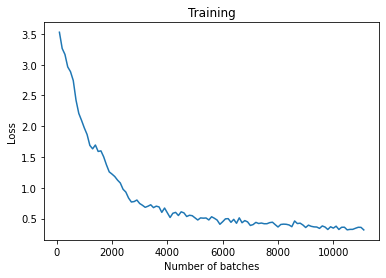

In [22]:
plt.plot(np.linspace(LOGGING_STEPS, LOGGING_STEPS * len(history), len(history)), history)
plt.xlabel("Number of batches")
plt.ylabel("Loss")
plt.title("Training")
plt.show()

### Test on testset

In [20]:
y_true_ner = []
y_pred_ner = []
y_true_rel = []
y_pred_rel = []
for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['label'].to(device)
        relations = data['relations'].to(device)

        # Predict
        ner_outputs, rel_outputs = model(input_ids=input_ids, 
                                         attention_mask=attention_mask, 
                                         token_type_ids=token_type_ids)
        

        # Add predictions and labels to list
        y_pred_ner += ner_outputs.view(-1, ner_outputs.shape[-1]).argmax(axis=1).tolist()
        y_true_ner += labels.view(-1).tolist()
        y_pred_rel += rel_outputs.argmax(axis=1).tolist()
        y_true_rel += relations.tolist()

In [21]:
print("Performance on testset:\n" + 
      "NER:\n"
      "Accuracy: {:.4f}\n".format(accuracy_score(y_true_ner, y_pred_ner)) + 
      "Precision: {:.4f}\n".format(precision_score(y_true_ner, y_pred_ner, average='weighted')) + 
      "Recall: {:.4f}\n".format(recall_score(y_true_ner, y_pred_ner, average='weighted')) + 
      "F1-Score: {:.4f}".format(f1_score(y_true_ner, y_pred_ner, average='weighted')) +
      "\nRE:\n" + 
      "Accuracy: {:.4f}\n".format(accuracy_score(y_true_rel, y_pred_rel)) + 
      "Precision: {:.4f}\n".format(precision_score(y_true_rel, y_pred_rel, average='weighted')) + 
      "Recall: {:.4f}\n".format(recall_score(y_true_rel, y_pred_rel, average='weighted')) + 
      "F1-Score: {:.4f}".format(f1_score(y_true_rel, y_pred_rel, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance on testset:
NER:
Accuracy: 0.0014
Precision: 0.1148
Recall: 0.0014
F1-Score: 0.0015
RE:
Accuracy: 0.0109
Precision: 0.0167
Recall: 0.0109
F1-Score: 0.0109


In [25]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MRP1/TwoHeadedBertModel_all_3ep.pth')

## DEMO

In [19]:
# LOAD MODEL
model = TwoHeadedBERTModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/MRP1/TwoHeadedBertModel_all_3ep.pth'))
model.to(device);

# Load dict with idx2tok and tok2idx
idx2tok_ner = {int(k):v for k,v in load_dic("/content/drive/MyDrive/MRP1/idx2tok_ner").items()}
idx2tok_rel = {int(k):v for k,v in load_dic("/content/drive/MyDrive/MRP1/idx2tok_rel").items()}
tok2idx_ner = {k:int(v) for k,v in load_dic("/content/drive/MyDrive/MRP1/tok2idx_ner").items()}
tok2idx_rel = {k:int(v) for k,v in load_dic("/content/drive/MyDrive/MRP1/tok2idx_rel").items()}

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
f1_score(y_true_rel, y_pred_rel, average=None)

array([0.        , 0.        , 0.00621601, 0.00096154, 0.        ,
       0.        , 0.        , 0.0010582 , 0.        , 0.        ,
       0.00357782, 0.00489796, 0.        , 0.        , 0.00153374,
       0.93939394, 0.00322407, 0.00407   , 0.        , 0.        ])

In [127]:
# Create functions needed
def output2labels_ner(ner_outputs):
  return [[idx2tok_ner[idx] for idx in ner_outputs.argmax(axis=2).cpu().tolist()[i]] for i in range(ner_outputs.shape[0])]

def output2labels_rel(rel_outputs):
  return [idx2tok_rel[idx] for idx in rel_outputs.argmax(axis=1).cpu().tolist()]

def get_SVO(sentence):
  sentences = [sentence] 

  # Tokenize input
  tokens = tokenizer.tokenize(sentences[0]) 
  tokenized = tokenizer(sentences, max_length=MAX_INPUT_LENGTH, padding='max_length', truncation=True)

  # Create dataset
  encodings = {'input_ids': torch.tensor(tokenized.input_ids),
              'attention_mask': torch.tensor(tokenized.attention_mask),
              'token_type_ids': torch.tensor(tokenized.token_type_ids)}

  dataset = Dataset(encodings)

  # Get output of Two Headed Bert Model
  ner_outputs, rel_outputs = model(input_ids = dataset[None, 0]['input_ids'].to(device),
          attention_mask = dataset[None, 0]['attention_mask'].to(device),
          token_type_ids = dataset[None, 0]['token_type_ids'].to(device))
    
  # List with all correct NEs relations
  rel_with_ne = {'QUASHEDJUDGMENT':[["DATE"], ["COURT"]],
                 'ACQUITTED':[["DATE"], ["COURT"]],
                 'QUASHEDDECISION':[["DATE"], ["COURT"]],
                 'LAWYER':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'ACCUSED':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'ALLEGED':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'AUTHORISED':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON", "ORG", "NORP"]],
                 'BORNIN':[["ORG", "JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["DATE", "GPE"]],
                 'SENTENCED':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["DATE"]],
                 'APPEALEDON':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["DATE"]],
                 'RESIDENT':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["GPE"]],
                 'CITIZEN':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["GPE"]],
                 'PRACTISINGIN':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["GPE"]],
                 'DETAINEDIN':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["GPE"]],
                 'CLAIM':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["MONEY"]],
                 'RECEIVED':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["MONEY"]],
                 'SOUGHTREPARATION':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["MONEY"]],
                 'SOUGHTREIMBURSEMENT':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["MONEY"]],
                 'VIOLATED':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON", "ORG", "NORP"], ["ARTICLE", "RULE", "LAW"]],
                 'BREACHED':[["ORG", "JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["ARTICLE", "RULE", "LAW"]],
                 'COMPLAINEDUNDER':[["ORG", "JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["ARTICLE", "RULE", "LAW"]],
                 'ALLEGEDBREACH':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["ARTICLE", "RULE", "LAW"]],
                 'GRANTEDLEAVE':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["RULE", "LAW"]],
                 'LODGEDCOMPLAINTWITH':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["NORP", "ORG"]],
                 'APPEALEDTO':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["COURT", "NORP", "ORG"]],
                 'LODGEDCOMPLAINTAGAINST':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["NORP", "ORG"]],
                 'APPEALEDAGAINST':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["NORP", "ORG"]],
                 'INFORMED':[["ORG", "JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["COURT", "JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'CHALLENGEDDECISION':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["COURT"]],
                 'SUBMITTED':[["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"], ["COURT", "DATE"]],
                 'COMPOSED':[["ORG"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'REPRESENTEDBY':[["ORG", "NORP"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'APPOINTED':[["ORG", "NORP"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'DELIBERATED':[["ORG"], ["DATE"]],
                 'ORIGINATES':[["ORG"], ["DATE"]],
                 'APPOINTEDBASEDON':[["ORG", "NORP"], ["RULE", "ARTICLE", "LAW"]],
                 'CHAMBERCOMPOSITION':[["COURT", "NORP"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'CONVICTED':[["COURT"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'INDICTMENTAGAINST':[["COURT", "PROSECUTOR"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON", "ORG", "NORP"]],
                 'FOUNDVIOLATION':[["COURT", "ORG"], ["ARTICLE", "RULE", "PROTOCOL", "LAW"]],
                 'FOUNDNOVIOLATION':[["COURT", "ORG"], ["ARTICLE", "RULE", "PROTOCOL", "LAW"]],
                 'CITED':[["COURT"], ["ARTICLE", "RULE", "PROTOCOL", "LAW"]],
                 'HOLDSVIOLATION':[["COURT"], ["PROTOCOL", "LAW"]],
                 'ACCEDEDREQUEST':[["COURT"], ["DATE"]],
                 'DISMISSEDON':[["COURT"], ["DATE"]],
                 'RATIFIEDON':[["COURT"], ["DATE"]],
                 'DECISIONUNDER':[["NORP"], ["RULE", "ARTICLE", "LAW"]],
                 'AGAINST':[["APPLICATION"], ["GPE"]],
                 'FILEDIN':[["APPLICATION"], ["GPE"]],
                 'DISMISSEDIN':[["APPLICATION"], ["GPE"]],
                 'LODGEDBY':[["APPLICATION", "CASE"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'LODGEDAGAINST':[["APPLICATION", "CASE"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'CONCERNING':[["APPLICATION"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'LODGEDIN':[["APPLICATION"], ["DATE"]],
                 'SUBMITTEDON':[["APPLICATION"], ["DATE"]],
                 'RELIEDON':[["APPLICATION"], ["DATE"]],
                 'LODGEDUNDER':[["APPLICATION"], ["ARTICLE", "LAW"]],
                 'INVOKED':[["APPLICATION"], ["ARTICLE", "LAW"]],
                 'REITERATED':[["APPLICATION"], ["ARTICLE", "LAW"]],
                 'REFERREDBY':[["CASE"], ["ORG"]],
                 'REFERREDTO':[["CASE"], ["ORG", "COURT", "APPLICATION"]],
                 'FILEDAGAINST':[["CASE"], ["ORG", "JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON"]],
                 'REFERREDON':[["CASE"], ["DATE"]],
                 'ORIGINATEDON':[["CASE"], ["DATE"]],
                 'SETTLEDON':[["CASE"], ["DATE"]],
                 'REMITTEDTO':[["CASE"], ["COURT"]],
                 'SUBMITTEDTO':[["CASE"], ["COURT"]],
                 'ORIGINATEDIN':[["CASE"], ["APPLICATION"]],
                 'INCLUDED':[["CASE"], ["APPLICATION"]],
                 'INDICTMENTAGAINST':[["PROSECUTOR"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON", "ORG", "NORP"]],
                 'PROSECUTED':[["PROSECUTOR"], ["JUDGE", "REGISTRAR", "SECRETARY", "LAWYER", "DEFENDANT", "INVESTIGATORS", "PROSECUTOR", "PERSON", "ORG"]],
                 'ORDEREDAGAINST':[["PROSECUTOR"], ["NORP"]],
                 'REQUESTED':[["PROSECUTOR"], ["COURT"]],
                 'NOTED':[["PROSECUTOR"], ["COURT"]],
                 'REQUESTEDON':[["PROSECUTOR"], ["COURT"]],
                 'PROSECUTEDON':[["PROSECUTOR"], ["COURT"]],
                 }

  # Numerical output to label (string) 
  entities = [[],[]]
  print(output2labels_rel(rel_outputs)[0])
  if output2labels_rel(rel_outputs)[0] != 'NEGATIVE':
    nes = rel_with_ne[output2labels_rel(rel_outputs)[0]]
    tags = output2labels_ner(ner_outputs)

    # Find correct entities in text
    nes_idx = 0
    i = 0
    while i < len(tags[0]) and nes_idx < 2:
      for ne in nes[nes_idx]:
        if ne in tags[0][i]:
          scope = True
          j = 0
          while scope:
            if ne in tags[0][i+j]:
              entities[nes_idx].append(i+j)
              j += 1
            else:
              i += j - 1
              scope = False
          nes_idx += 1

          break
      i += 1

  # Print results
  if entities[1] == [] or max(entities[1]) >= len(tokens):
    print("No relation found.")
  else:
    print("Subject: {}".format(' '.join([tokens[x] for x in entities[0]])))
    print("Verb: {}".format(output2labels_rel(rel_outputs)[0]))
    print("Object: {}".format(' '.join([tokens[x] for x in entities[1]])))

In [99]:
get_SVO("In this context , the Court notes that the origin of the violation found under Article 1 of Protocol No . 1 was the absence of compensation for such interference with the applicant company 's property rights and not , as the applicant company puts it , the unlawful taking of its property ( see the principal judgment , § § 52 , 60 , and 61 ) .")

Subject: court
Verb: FOUNDVIOLATION
Object: article 1 of protocol no


In [143]:
get_SVO("The applicant was represented by Mr Kostyantyn Buzadzhy , a lawyer practising in Kyiv .")

LAWYER
Subject: by
Verb: LAWYER
Object: kost ##yan ##ty


In [130]:
get_SVO("The applicants were born in 1963 and 1950 respectively and live in . ")

BORNIN
No relation found.
